# Professional League of Legends Player Impact Estimation

In [19]:
import os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Load Data



In [21]:
# load data files
df = pd.read_csv("game_players_stats.csv")
meta = pd.read_csv("game_metadata.csv")

# merge metadata
meta_small = meta[['game_id','date','match_id','tournament_id','tournament_name',
                   'series_id','series_name','league_id','league_name']].copy()
df = df.merge(meta_small, on='game_id', how='left')

print("player rows:", len(df))
display(df.head(3))

player rows: 374554


,game_id,player_id,player_name,team_id,team_name,team_acronym,role,win,game_length,champion_name,...,largest_killing_spree,largest_multi_kill,date,match_id,tournament_id,tournament_name,series_id,series_name,league_id,league_name
0,15,0,shanji,0,Legend Esport Gaming,LEG,Top,False,1415,Irelia,...,0,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
1,15,1,Demon,1,Bilibili Gaming Junior,BLGJ,Top,True,1415,Vladimir,...,2,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL
2,15,2,yanxuan,0,Legend Esport Gaming,LEG,Bot,False,1415,Kai'Sa,...,0,1,2019-09-15 06:03:38.000000,4,4,Playoffs,4,LDL Summer 2019,4,LDL


### Clean & Filter

In [22]:
# Normalize role labels; map 'Bot' -> 'ADC'
df['role'] = df['role'].astype(str).str.strip().replace({'Bot':'ADC'})

valid_roles = ['Top','Jungle','Mid','ADC','Support']
df = df[df['role'].isin(valid_roles)].copy()

# filter players with more than 100 games
game_floor = 50
games_per_player = df.groupby("player_name").size()
eligible_players = games_per_player[games_per_player > game_floor].index.tolist()
df = df[df["player_name"].isin(eligible_players)].copy()

print(f"Rows after filtering (>{game_floor} games players):", len(df))
print("Eligible players:", len(eligible_players))

# map win to numeric
df['win'] = df['win'].map({True:1, False:0, 'True':1, 'False':0}).astype(float).fillna(0.0)

# parse date and sort (time-aware split later)
if 'date' in df.columns and df['date'].notnull().any():
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)
    print("Sorted by date")
else:
    df = df.sort_values('game_id').reset_index(drop=True)
    print("Sorted by game_id")

Rows after filtering (>50 games players): 326338
Eligible players: 1950
Sorted by date


### Role Normalization

In [23]:
# Numeric per-player stats z-scored within each role
stat_cols = [
    'player_kills','player_deaths','player_assists',
    'total_minions_killed','gold_earned','level',
    'total_damage_dealt','total_damage_dealt_to_champions',
    'total_damage_taken','wards_placed','largest_killing_spree','largest_multi_kill'
]

# ensure stats exist (if any missing, create with zeros)
for c in stat_cols:
    if c not in df.columns:
        df[c] = 0.0

# Fill missing with 0 (conservative)
df[stat_cols] = df[stat_cols].fillna(0.0)

# Role-normalize: z-score per role
# Use ddof=0 for population std (avoid tiny sample problems). Add eps to denom.
eps = 1e-9
for c in stat_cols:
    role_means = df.groupby('role')[c].transform('mean')
    role_stds  = df.groupby('role')[c].transform(lambda x: x.std(ddof=0)).replace(0, eps)
    df[c + '_rnorm'] = (df[c] - role_means) / (role_stds + eps)

# New stat feature list (role-normalized)
stat_rnorm_cols = [c + '_rnorm' for c in stat_cols]
print("Role-normalized stat cols:", stat_rnorm_cols)
display(df[stat_rnorm_cols].head())

Role-normalized stat cols: ['player_kills_rnorm', 'player_deaths_rnorm', 'player_assists_rnorm', 'total_minions_killed_rnorm', 'gold_earned_rnorm', 'level_rnorm', 'total_damage_dealt_rnorm', 'total_damage_dealt_to_champions_rnorm', 'total_damage_taken_rnorm', 'wards_placed_rnorm', 'largest_killing_spree_rnorm', 'largest_multi_kill_rnorm']


,player_kills_rnorm,player_deaths_rnorm,player_assists_rnorm,total_minions_killed_rnorm,gold_earned_rnorm,level_rnorm,total_damage_dealt_rnorm,total_damage_dealt_to_champions_rnorm,total_damage_taken_rnorm,wards_placed_rnorm,largest_killing_spree_rnorm,largest_multi_kill_rnorm
0,-0.307375,1.145946,-1.148058,-1.330344,-1.375094,-2.623750,-1.176613,-1.119972,-0.990264,-0.974878,-0.849722,-0.100798
1,-0.307375,0.099505,0.238807,-1.423226,-1.362464,-1.341016,-1.155325,-0.691030,-0.865983,-0.332465,0.166106,-0.100798
2,0.157190,-1.000384,0.356874,0.216406,-0.088472,-0.239602,0.185101,-0.830392,-0.889632,-1.228554,-0.352358,0.903536
3,0.917425,-1.449723,-0.481996,-1.226501,-0.545428,-0.861131,-1.141501,-0.611946,-1.155445,0.722128,1.594723,-0.044888
4,0.548959,-0.766830,0.188598,0.599783,0.966798,1.036590,0.362612,0.036111,0.300639,-0.040201,1.116804,0.536778


### Compute Team-Aggregate and Enemy-Aggregate Features

In [24]:
# Compute per-game per-team aggregates and merge them into each player role
agg_stat_cols = stat_rnorm_cols.copy()

# team means & sums using role-normalized stats
team_grp = df.groupby(['game_id','team_id'])
team_means = team_grp[agg_stat_cols].mean().add_prefix('team_mean_').reset_index()
team_sums  = team_grp[agg_stat_cols].sum().add_prefix('team_sum_').reset_index()
team_sizes = team_grp.size().reset_index(name='team_size')

# merge into df
df = df.merge(team_means, on=['game_id','team_id'], how='left')
df = df.merge(team_sums, on=['game_id','team_id'], how='left')
df = df.merge(team_sizes, on=['game_id','team_id'], how='left')

# team-ex-player mean (excluding the player's own normalized stat)
for s in agg_stat_cols:
    df[f'team_ex_player_mean_{s}'] = ((df[f'team_sum_{s}'] - df[s]) / df['team_size'].replace(1, np.nan))
    df[f'team_ex_player_mean_{s}'] = df[f'team_ex_player_mean_{s}'].fillna(df[f'team_mean_{s}'])

# Build lookup for opposing team means (enemy team)
team_means_lookup = team_means.groupby('game_id').apply(lambda g: g.set_index('team_id').to_dict('index')).to_dict()

def enemy_means_row(game_id, team_id):
    d = team_means_lookup.get(game_id, {})
    for t_id, row in d.items():
        if t_id != team_id:
            # prefix keys with enemy_
            return {('enemy_' + k): v for k,v in row.items()}
    # fallback: zeros
    return {('enemy_team_mean_' + c): 0.0 for c in agg_stat_cols}

enemy_df = df.apply(lambda r: pd.Series(enemy_means_row(r['game_id'], r['team_id'])), axis=1)
df = pd.concat([df.reset_index(drop=True), enemy_df.reset_index(drop=True)], axis=1)

# fill NA
df.fillna(0.0, inplace=True)

# collect aggregation columns to feed the model (team_ex_player_means + enemy means)
team_agg_cols = [c for c in df.columns if c.startswith('team_ex_player_mean_')]
enemy_agg_cols = [c for c in df.columns if c.startswith('enemy_team_mean_') or c.startswith('enemy_team_mean_') or c.startswith('enemy_team_mean_')]
# fallback: any column with 'enemy_' and any stat substring
if len(enemy_agg_cols) < len(agg_stat_cols):
    enemy_agg_cols = [c for c in df.columns if c.startswith('enemy_') and any(s in c for s in agg_stat_cols)]

numeric_agg = team_agg_cols + enemy_agg_cols
print("Numeric aggregate count:", len(numeric_agg))
display(df[[*agg_stat_cols][:3] + numeric_agg[:6]].head())

# Categorical encoding for embeddings & prepare numeric aggregates
cat_cols = ['player_id','player_name','champion_name','role','team_id','team_name','league_name','tournament_name','series_name']
for c in cat_cols:
    df[c] = df[c].fillna('Unknown').astype(str)

encoders = {}
for c in ['player_id','champion_name','role','team_id','league_name','tournament_name','series_name']:
    le = LabelEncoder()
    df[c + '_idx'] = le.fit_transform(df[c])
    encoders[c] = le
    print(c, "->", df[c + '_idx'].nunique(), "unique")

# scale numeric_agg array (these are now role-normalized stats aggregated across teams)
if len(numeric_agg) == 0:
    df['dummy_agg'] = 0.0
    numeric_agg = ['dummy_agg']

scaler = StandardScaler()
df[numeric_agg] = scaler.fit_transform(df[numeric_agg].values)

# build input arrays
X_player = df['player_id_idx'].values.astype(np.int64)
X_champ  = df['champion_name_idx'].values.astype(np.int64)
X_role   = df['role_idx'].values.astype(np.int64)
X_team   = df['team_id_idx'].values.astype(np.int64)
X_league = df['league_name_idx'].values.astype(np.int64)
X_tourn  = df['tournament_name_idx'].values.astype(np.int64)
X_series = df['series_name_idx'].values.astype(np.int64)
X_numagg = df[numeric_agg].values.astype(np.float32)
y_win    = df['win'].values.astype(np.float32)

num_players = df['player_id_idx'].nunique()
num_champs  = df['champion_name_idx'].nunique()
num_roles   = df['role_idx'].nunique()
num_teams   = df['team_id_idx'].nunique()
num_leagues = df['league_name_idx'].nunique()
num_tourns  = df['tournament_name_idx'].nunique()
num_series  = df['series_name_idx'].nunique()

print("Prepared inputs shape, numagg dim:", X_numagg.shape)

/tmp/ipython-input-2273827581.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_means_lookup = team_means.groupby('game_id').apply(lambda g: g.set_index('team_id').to_dict('index')).to_dict()


Numeric aggregate count: 24


,player_kills_rnorm,player_deaths_rnorm,player_assists_rnorm,team_ex_player_mean_player_kills_rnorm,team_ex_player_mean_player_deaths_rnorm,team_ex_player_mean_player_assists_rnorm,team_ex_player_mean_total_minions_killed_rnorm,team_ex_player_mean_gold_earned_rnorm,team_ex_player_mean_level_rnorm
0,-0.307375,1.145946,-1.148058,-0.307375,1.145946,-1.148058,-1.330344,-1.375094,-2.623750
1,-0.307375,0.099505,0.238807,0.358205,-0.816702,-0.041707,-0.336698,-0.211300,-0.366911
2,0.157190,-1.000384,0.356874,0.203350,-0.450073,-0.081063,-0.883242,-0.635964,-0.734049
3,0.917425,-1.449723,-0.481996,-0.050062,-0.300293,0.198561,-0.402273,-0.483645,-0.526873
4,0.548959,-0.766830,0.188598,0.176640,-0.303158,0.511615,0.299876,0.739334,0.837629


player_id -> 2017 unique
champion_name -> 168 unique
role -> 5 unique
team_id -> 753 unique
league_name -> 65 unique
tournament_name -> 56 unique
series_name -> 385 unique
Prepared inputs shape, numagg dim: (326338, 24)


In [25]:
# time-aware split by game_id (train/val/test)
unique_games = df['game_id'].unique()
unique_games = np.sort(unique_games)
n = len(unique_games)
train_cut = int(n * 0.7)
val_cut   = int(n * 0.85)

train_games = unique_games[:train_cut]
val_games   = unique_games[train_cut:val_cut]
test_games  = unique_games[val_cut:]

mask_train = df['game_id'].isin(train_games)
mask_val   = df['game_id'].isin(val_games)
mask_test  = df['game_id'].isin(test_games)

print("train/val/test rows:", mask_train.sum(), mask_val.sum(), mask_test.sum())

train/val/test rows: 228191 49617 48530


In [26]:
# Dataset & Dataloader
class Dataset(Dataset):
    def __init__(self, player, champ, role, team, league, tourn, series, numagg, y):
        self.player = torch.tensor(player, dtype=torch.long)
        self.champ  = torch.tensor(champ, dtype=torch.long)
        self.role   = torch.tensor(role, dtype=torch.long)
        self.team   = torch.tensor(team, dtype=torch.long)
        self.league = torch.tensor(league, dtype=torch.long)
        self.tourn  = torch.tensor(tourn, dtype=torch.long)
        self.series = torch.tensor(series, dtype=torch.long)
        self.numagg = torch.tensor(numagg, dtype=torch.float32)
        self.y      = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return (self.player[idx], self.champ[idx], self.role[idx], self.team[idx],
                self.league[idx], self.tourn[idx], self.series[idx], self.numagg[idx], self.y[idx])

BATCH = 256
train_ds = Dataset(X_player[mask_train], X_champ[mask_train], X_role[mask_train], X_team[mask_train],
                         X_league[mask_train], X_tourn[mask_train], X_series[mask_train], X_numagg[mask_train], y_win[mask_train])
val_ds   = Dataset(X_player[mask_val], X_champ[mask_val], X_role[mask_val], X_team[mask_val],
                         X_league[mask_val], X_tourn[mask_val], X_series[mask_val], X_numagg[mask_val], y_win[mask_val])
test_ds  = Dataset(X_player[mask_test], X_champ[mask_test], X_role[mask_test], X_team[mask_test],
                         X_league[mask_test], X_tourn[mask_test], X_series[mask_test], X_numagg[mask_test], y_win[mask_test])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH)
test_loader  = DataLoader(test_ds, batch_size=BATCH)

print("Data loaders ready; example batch shapes:")
batch = next(iter(train_loader))
print([b.shape for b in batch[:8]])

Data loaders ready; example batch shapes:
[torch.Size([256]), torch.Size([256]), torch.Size([256]), torch.Size([256]), torch.Size([256]), torch.Size([256]), torch.Size([256]), torch.Size([256, 24])]


## Model

In [27]:
class PlayerImpactModel(nn.Module):
    def __init__(self,
                 n_players, n_champs, n_roles, n_teams, n_leagues, n_tourns, n_series,
                 numagg_dim,
                 p_emb=64, c_emb=32, r_emb=8, t_emb=16, l_emb=8, tn_emb=8, s_emb=8,
                 hidden=[256,128], z_dim=64, dropout=0.3):
        super().__init__()
        self.player_emb = nn.Embedding(n_players, p_emb)
        self.champ_emb  = nn.Embedding(n_champs, c_emb)
        self.role_emb   = nn.Embedding(n_roles, r_emb)
        self.team_emb   = nn.Embedding(n_teams, t_emb)
        self.league_emb = nn.Embedding(n_leagues, l_emb)
        self.tourn_emb  = nn.Embedding(n_tourns, tn_emb)
        self.series_emb = nn.Embedding(n_series, s_emb)

        # combined input dims; player_vector (player+role) will be included
        in_dim = p_emb + r_emb + c_emb + t_emb + l_emb + tn_emb + s_emb + numagg_dim
        layers = []
        for h in hidden:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, z_dim))
        layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)

        self.win_head = nn.Linear(z_dim, 1)
        self.score_head = nn.Linear(z_dim, 1)

    def forward(self, player, champ, role, team, league, tourn, series, numagg):
        p = self.player_emb(player)
        r = self.role_emb(role)
        player_vector = torch.cat([p, r], dim=1)   # role baked into player vector
        c = self.champ_emb(champ)
        t = self.team_emb(team)
        l = self.league_emb(league)
        tn = self.tourn_emb(tourn)
        s = self.series_emb(series)
        x = torch.cat([player_vector, c, t, l, tn, s, numagg], dim=1)
        z = self.encoder(x)
        logits = self.win_head(z).squeeze(1)
        score = self.score_head(z).squeeze(1)
        return logits, score, z, player_vector

model = PlayerImpactModel(
    n_players=num_players, n_champs=num_champs, n_roles=num_roles, n_teams=num_teams,
    n_leagues=num_leagues, n_tourns=num_tourns, n_series=num_series,
    numagg_dim=X_numagg.shape[1],
    p_emb=64, c_emb=32, r_emb=8, t_emb=16, l_emb=8, tn_emb=8, s_emb=8,
    hidden=[128,64], z_dim=32, dropout=0.3
).to(device)

print(model)

PlayerImpactModel(
  (player_emb): Embedding(2017, 64)
  (champ_emb): Embedding(168, 32)
  (role_emb): Embedding(5, 8)
  (team_emb): Embedding(753, 16)
  (league_emb): Embedding(65, 8)
  (tourn_emb): Embedding(56, 8)
  (series_emb): Embedding(385, 8)
  (encoder): Sequential(
    (0): Linear(in_features=168, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
  )
  (win_head): Linear(in_features=32, out_features=1, bias=True)
  (score_head): Linear(in_features=32, out_features=1, bias=True)
)


In [28]:
# Loss, optimizer, scheduler, class weight
train_labels = y_win[mask_train]
pos = train_labels.sum(); neg = len(train_labels) - pos
pos_weight = (neg / (pos + 1e-9)) if pos>0 else 1.0
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)
print("pos_weight:", pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

EPOCHS = 12
best_val_auc = -np.inf
early_stop_patience = 4
no_improve = 0
history = {'train_loss':[], 'val_loss':[], 'train_auc':[], 'val_auc':[]}

pos_weight: 0.9193941


## Training Loop

In [29]:
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    preds_train=[]; labs_train=[]
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} train", leave=False)
    for (player, champ, role, team, league, tourn, series, numagg, y) in pbar:
        player = player.to(device); champ=champ.to(device); role=role.to(device)
        team = team.to(device); league=league.to(device); tourn=tourn.to(device); series=series.to(device)
        numagg = numagg.to(device); y = y.to(device).squeeze(1)

        optimizer.zero_grad()
        logits, score, z, pvec = model(player, champ, role, team, league, tourn, series, numagg)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * player.size(0)
        preds_train.append(torch.sigmoid(logits.detach()).cpu().numpy())
        labs_train.append(y.detach().cpu().numpy())
        pbar.set_postfix({'loss':loss.item()})

    train_loss = running_loss / len(train_ds)
    train_preds_flat = np.concatenate(preds_train)
    train_trues_flat = np.concatenate(labs_train)
    train_auc = roc_auc_score(train_trues_flat, train_preds_flat) if len(np.unique(train_trues_flat))>1 else float('nan')

    # validation
    model.eval()
    v_loss = 0.0; v_preds=[]; v_trues=[]
    with torch.no_grad():
        for (player, champ, role, team, league, tourn, series, numagg, y) in val_loader:
            player = player.to(device); champ=champ.to(device); role=role.to(device)
            team = team.to(device); league=league.to(device); tourn=tourn.to(device); series=series.to(device)
            numagg = numagg.to(device); y = y.to(device).squeeze(1)
            logits, score, z, pvec = model(player, champ, role, team, league, tourn, series, numagg)
            v_loss += criterion(logits, y).item() * player.size(0)
            v_preds.append(torch.sigmoid(logits.cpu()).numpy())
            v_trues.append(y.cpu().numpy())

    val_loss = v_loss / len(val_ds)
    v_preds_flat = np.concatenate(v_preds)
    v_trues_flat = np.concatenate(v_trues)
    val_auc = roc_auc_score(v_trues_flat, v_preds_flat) if len(np.unique(v_trues_flat))>1 else float('nan')

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_auc'].append(train_auc); history['val_auc'].append(val_auc)

    print(f"Epoch {epoch}/{EPOCHS} train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_auc={train_auc:.4f} val_auc={val_auc:.4f}")

    if val_auc > best_val_auc and not np.isnan(val_auc):
        best_val_auc = val_auc
        torch.save({'model_state':model.state_dict(), 'encoders':{k:encoders[k].classes_.tolist() for k in encoders}}, "model.pt")
        no_improve = 0
        print(f"Saved best model at epoch {epoch} val_auc {val_auc:.4f}")
    else:
        no_improve += 1

    if no_improve >= early_stop_patience:
        print("Early stopping")
        break

Epoch 1 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 1/12 train_loss=0.2135 val_loss=0.0893 train_auc=0.9765 val_auc=0.9946
Saved best model at epoch 1 val_auc 0.9946


Epoch 2 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 2/12 train_loss=0.0905 val_loss=0.0730 train_auc=0.9943 val_auc=0.9963
Saved best model at epoch 2 val_auc 0.9963


Epoch 3 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 3/12 train_loss=0.0789 val_loss=0.0692 train_auc=0.9956 val_auc=0.9967
Saved best model at epoch 3 val_auc 0.9967


Epoch 4 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 4/12 train_loss=0.0742 val_loss=0.0653 train_auc=0.9961 val_auc=0.9970
Saved best model at epoch 4 val_auc 0.9970


Epoch 5 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 5/12 train_loss=0.0701 val_loss=0.0640 train_auc=0.9965 val_auc=0.9972
Saved best model at epoch 5 val_auc 0.9972


Epoch 6 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 6/12 train_loss=0.0674 val_loss=0.0624 train_auc=0.9967 val_auc=0.9973
Saved best model at epoch 6 val_auc 0.9973


Epoch 7 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 7/12 train_loss=0.0651 val_loss=0.0608 train_auc=0.9969 val_auc=0.9974
Saved best model at epoch 7 val_auc 0.9974


Epoch 8 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 8/12 train_loss=0.0623 val_loss=0.0599 train_auc=0.9971 val_auc=0.9975
Saved best model at epoch 8 val_auc 0.9975


Epoch 9 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 9/12 train_loss=0.0605 val_loss=0.0594 train_auc=0.9973 val_auc=0.9975
Saved best model at epoch 9 val_auc 0.9975


Epoch 10 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 10/12 train_loss=0.0598 val_loss=0.0586 train_auc=0.9974 val_auc=0.9976
Saved best model at epoch 10 val_auc 0.9976


Epoch 11 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 11/12 train_loss=0.0584 val_loss=0.0584 train_auc=0.9975 val_auc=0.9977
Saved best model at epoch 11 val_auc 0.9977


Epoch 12 train:   0%|          | 0/892 [00:00<?, ?it/s]

Epoch 12/12 train_loss=0.0570 val_loss=0.0587 train_auc=0.9976 val_auc=0.9976


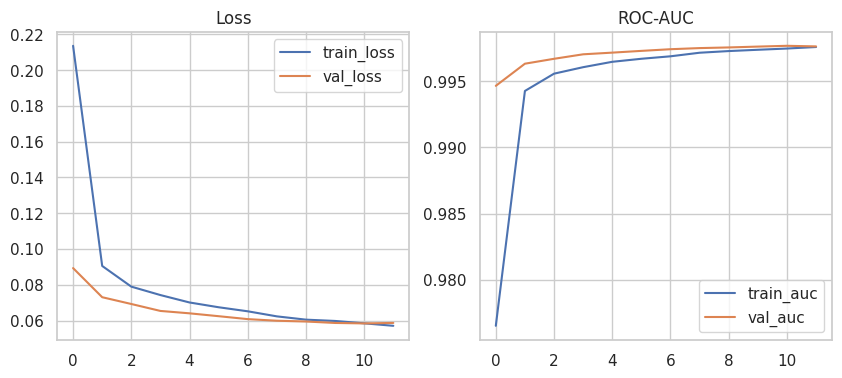

In [30]:
# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss'); plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_auc'], label='train_auc'); plt.plot(history['val_auc'], label='val_auc')
plt.legend(); plt.title('ROC-AUC')
plt.show()

## Evaluation - Run from here given existing pretrained model

### Model Evaluation

In [31]:
# load best checkpoint if it exists
if os.path.exists("model.pt"):
    ck = torch.load("model.pt", map_location=device)
    model.load_state_dict(ck['model_state'])
    print("Loaded best checkpoint.")

model.eval()
all_probs=[]; all_scores=[]; all_labels=[]
with torch.no_grad():
    for (player, champ, role, team, league, tourn, series, numagg, y) in test_loader:
        player = player.to(device); champ=champ.to(device); role=role.to(device)
        team = team.to(device); league=league.to(device); tourn=tourn.to(device); series=series.to(device)
        numagg = numagg.to(device); y = y.to(device).squeeze(1)
        logits, score, z, pvec = model(player, champ, role, team, league, tourn, series, numagg)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs); all_scores.append(score.cpu().numpy()); all_labels.append(y.cpu().numpy())
all_probs = np.concatenate(all_probs); all_scores = np.concatenate(all_scores); all_labels = np.concatenate(all_labels)

acc = accuracy_score(all_labels, (all_probs>=0.5).astype(int))
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, (all_probs>=0.5).astype(int))
print("Test acc:", acc)
print("Test AUC:", auc)
print("Confusion matrix:\n", cm)

Loaded best checkpoint.
Test acc: 0.9717906449618793
Test AUC: 0.9962253495483625
Confusion matrix:
 [[22611   528]
 [  841 24550]]


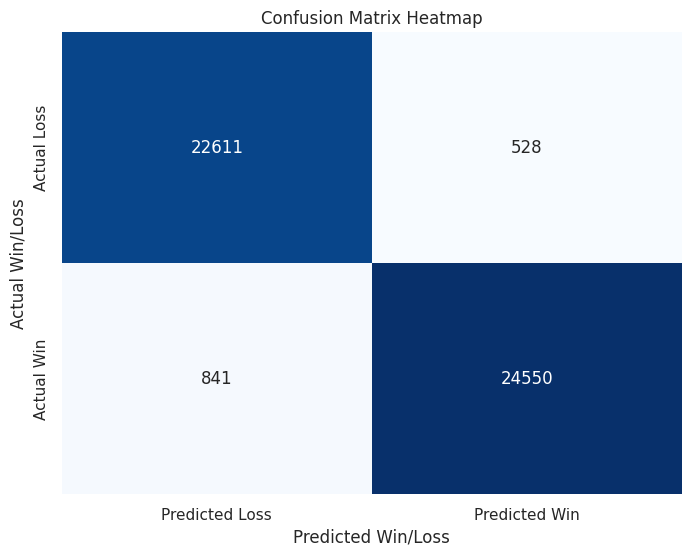

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted Win/Loss')
plt.ylabel('Actual Win/Loss')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Player-Champion-Team "Threat" Table

In [33]:
# Run model on the full dataset to get per-row predictions, hidden scores and player embeddings
full_ds = Dataset(X_player, X_champ, X_role, X_team, X_league, X_tourn, X_series, X_numagg, y_win)
full_loader = DataLoader(full_ds, batch_size=512)

rows_scores = []
rows_pvecs  = []
rows_preds  = []   # predicted win probs per row

with torch.no_grad():
    for (player, champ, role, team, league, tourn, series, numagg, y) in full_loader:
        player = player.to(device); champ = champ.to(device); role = role.to(device)
        team   = team.to(device); league = league.to(device); tourn = tourn.to(device); series = series.to(device)
        numagg = numagg.to(device)

        logits, score, z, pvec = model(player, champ, role, team, league, tourn, series, numagg)
        probs = torch.sigmoid(logits).cpu().numpy()

        rows_preds.append(probs.reshape(-1))
        rows_scores.append(score.cpu().numpy().reshape(-1))
        rows_pvecs.append(pvec.cpu().numpy())

# concatenate arrays
rows_preds = np.concatenate(rows_preds)
rows_scores = np.concatenate(rows_scores)
rows_pvecs = np.vstack(rows_pvecs)

# attach to df
df = df.reset_index(drop=True)
df['pred'] = rows_preds
df['hidden_score_raw'] = rows_scores
df['player_emb_row'] = list(rows_pvecs)

In [34]:
# Save full dataset model scores to csv
# Scale hidden_score_raw into 0–100
score_scaled = (df['hidden_score_raw'] - df['hidden_score_raw'].min()) / \
               (df['hidden_score_raw'].max() - df['hidden_score_raw'].min() + 1e-9)
df['score_scaled'] = score_scaled * 100

# Columns to export
score_export_cols = [
    'game_id', 'player_id', 'player_name', 'team_id', 'team_name',
    'role', 'champion_name', 'score_scaled'
]

# Save per-row continuous scores CSV
df[score_export_cols].to_csv("model_scores_per_row.csv", index=False)
print("Saved: model_scores_per_row.csv")

Saved: model_scores_per_row.csv


In [35]:
# Player-Champion-Team Board
# Make sure columns used exist: player_name, champion_name, team_name, pred
assert 'pred' in df.columns, "df['pred'] must contain predicted win probabilities."

# Use the correct column name 'champion_name'
config_agg = (
    df.groupby(['player_name', 'champion_name', 'team_name'])
      .agg(mean_winprob=('pred', 'mean'),
           games=('pred', 'count'))
      .reset_index()
)

# convert to 0-100 favorability
config_agg['favorability_0_100'] = config_agg['mean_winprob'] * 100

# filter by minimum games; can be adjusted
min_games = 5
if min_games > 1:
    config_agg = config_agg[config_agg['games'] >= min_games]

# sort and take top N (handle case where fewer than N)
N = 100
leaderboard = config_agg.sort_values('favorability_0_100', ascending=False).head(N).reset_index(drop=True)

# display columns
if leaderboard.empty:
    print("Leaderboard is empty (no configs passed min_games). Try lowering min_games.")
else:
    display(leaderboard[['player_name', 'champion_name', 'team_name',
                         'favorability_0_100', 'games']])

,player_name,champion_name,team_name,favorability_0_100,games
0,Driver,Rumble,Beyond Gaming,99.989838,6
1,knight,LeBlanc,Bilibili Gaming,99.989746,5
2,Kaiwing,Trundle,PSG Talon,99.989143,5
3,Faker,Vex,T1,99.989090,5
4,Ruler,Smolder,JD Gaming,99.988304,5
...,...,...,...,...,...
95,Bluerzor,Rek'Sai,Zero Tenacity,99.905220,8
96,Kiin,Jax,Gen.G,99.904343,5
97,Jelly,Ornn,Isurus,99.902222,5
98,Nomanz,Vayne,Unicorns of Love,99.900749,5


In [36]:
# Save top 100 configurations to csv
leaderboard.to_csv("player_champion_team_leaderboard.csv", index=False)
print("Saved: player_champion_team_leaderboard.csv")

Saved: player_champion_team_leaderboard.csv
